# Diabetes Prediction and Analysis

# Objective:

To build a predictive model that can accurately assess an individual’s likelihood of having diabetes based on clinical and lifestyle-related features.




In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')


In [51]:
url = "https://raw.githubusercontent.com/anuragraturi114/kaggle/refs/heads/main/diabetes_dataset.csv"
df = pd.read_csv(url)

In [52]:
df.head()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10000 non-null  int64  
 1   Age                            10000 non-null  int64  
 2   Sex                            10000 non-null  object 
 3   Ethnicity                      10000 non-null  object 
 4   BMI                            10000 non-null  float64
 5   Waist_Circumference            10000 non-null  float64
 6   Fasting_Blood_Glucose          10000 non-null  float64
 7   HbA1c                          10000 non-null  float64
 8   Blood_Pressure_Systolic        10000 non-null  int64  
 9   Blood_Pressure_Diastolic       10000 non-null  int64  
 10  Cholesterol_Total              10000 non-null  float64
 11  Cholesterol_HDL                10000 non-null  float64
 12  Cholesterol_LDL                10000 non-null  

,0
Unnamed: 0,0
Age,0
Sex,0
Ethnicity,0
BMI,0
Waist_Circumference,0
Fasting_Blood_Glucose,0
HbA1c,0
Blood_Pressure_Systolic,0
Blood_Pressure_Diastolic,0


## Creating Helper Functions For Analysis

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Numerical Distribution
def numerical_distro(data, numerical_features):
    for feature in numerical_features:
        plt.figure(figsize=(12, 5))

        # Histogram with KDE
        plt.subplot(1, 2, 1)
        sns.histplot(data=data, x=feature, kde=True, bins=30)
        plt.xlabel(feature)
        plt.ylabel("Frequency")

        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=data[feature])
        plt.title(f"Box Plot of {feature}")

        plt.tight_layout()
        plt.show()

        # Additional statistics
        print(f"\nStatistics for {feature}:")
        print(f"Skewness: {data[feature].skew():.2f}")
        print(f"Missing Values: {data[feature].isnull().sum()}")
        print("-" * 50)

# 2. Categorical Distribution
def categorical_distro(data, categorical_features, top_n=10):
    for feature in categorical_features:
        unique_count = data[feature].nunique()

        plt.figure(figsize=(10, 5))
        if unique_count > top_n:
            top_categories = data[feature].value_counts().nlargest(top_n)
            sns.barplot(x=top_categories.index, y=top_categories.values, palette='pastel')
            plt.title(f"Top {top_n} Categories of {feature}")
        else:
            sns.countplot(x=feature, data=data, order=data[feature].value_counts().index, palette='pastel')
            plt.title(f"Distribution of {feature}")

        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"Feature: {feature}")
        print(f"No. of Unique Values: {unique_count}")
        print(f"Missing Values: {data[feature].isnull().sum()}")
        print("-" * 50)

# 3. Numerical Correlation Analysis
def numerical_corr_analysis(data, numerical_features, target):
    for feature in numerical_features:
        if feature != target:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=data[feature], y=data[target], alpha=0.5)
            plt.title(f"{feature} vs {target}")
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.show()

    # Correlation heatmap
    corr_matrix = data[numerical_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

# 4. Categorical vs Target Analysis
def categorical_correlation_analysis(data, categorical_features, target, high_cardinality_threshold=10):
    for feature in categorical_features:
        if data[feature].nunique() <= high_cardinality_threshold:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=data[feature], y=data[target], palette='husl')
            plt.title(f"{feature} vs {target}")
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping {feature}:unique values ({data[feature].nunique()})\n")

# A binary target based on Fasting Blood Glucose threshold

In [54]:

if 'Fasting_Blood_Glucose' in df.columns:
    df['Diabetes'] = df['Fasting_Blood_Glucose'].apply(lambda x: 1 if x > 125 else 0)
    print('Target column "Diabetes" created  > 125.')
else:
    print('"Fasting_Blood_Glucose" column not found.')

Target column "Diabetes" created  > 125.


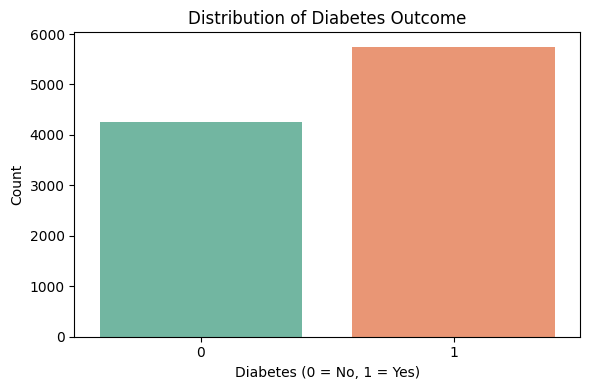

In [55]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Diabetes', data=df, palette='Set2')
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [56]:
numerical_cols = ['Age', 'BMI', 'Waist_Circumference', 'Fasting_Blood_Glucose',
                 'HbA1c', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
                 'Cholesterol_Total', 'Cholesterol_HDL', 'Cholesterol_LDL',
                 'GGT', 'Serum_Urate', 'Dietary_Intake_Calories',
                 'Family_History_of_Diabetes', 'Previous_Gestational_Diabetes', 'Diabetes']

categorical_cols = ['Sex', 'Ethnicity', 'Physical_Activity_Level',
                   'Alcohol_Consumption', 'Smoking_Status']


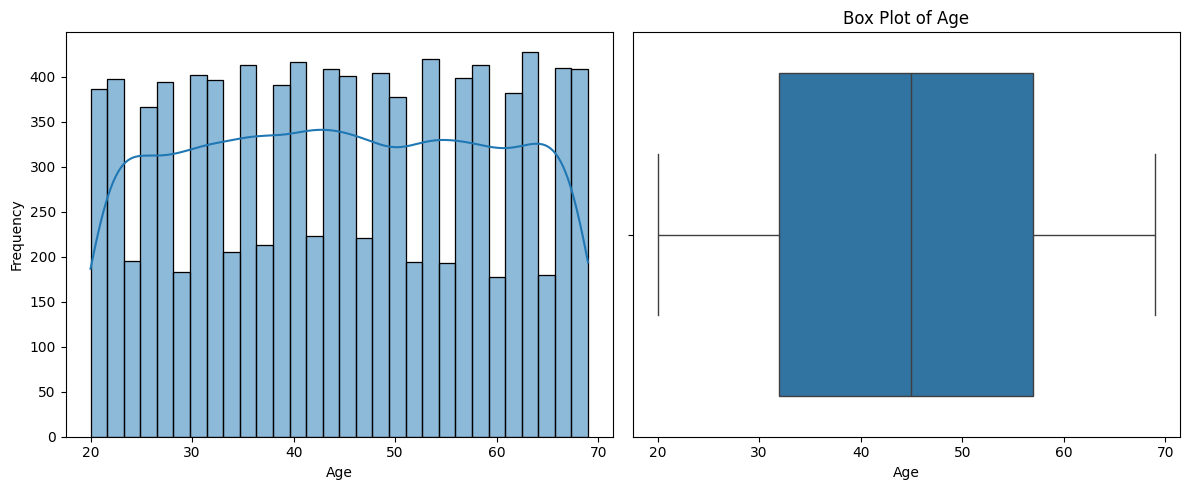


Statistics for Age:
Skewness: -0.00
Missing Values: 0
--------------------------------------------------


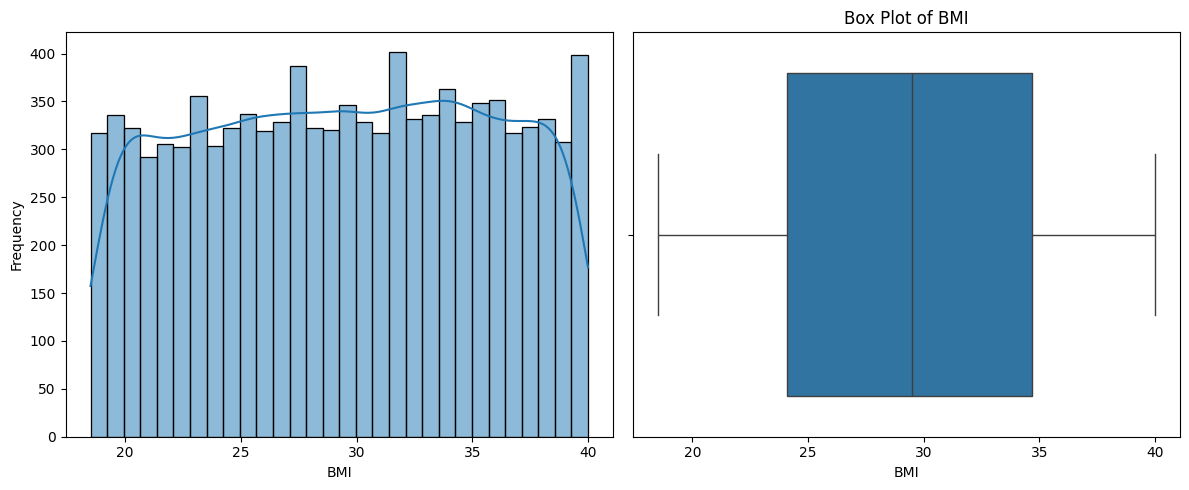


Statistics for BMI:
Skewness: -0.03
Missing Values: 0
--------------------------------------------------


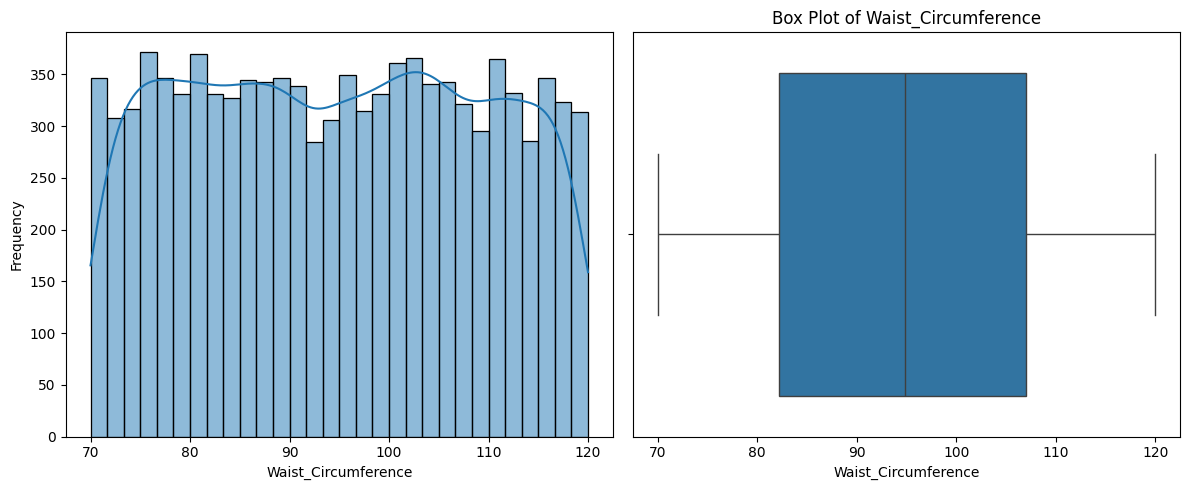


Statistics for Waist_Circumference:
Skewness: 0.01
Missing Values: 0
--------------------------------------------------


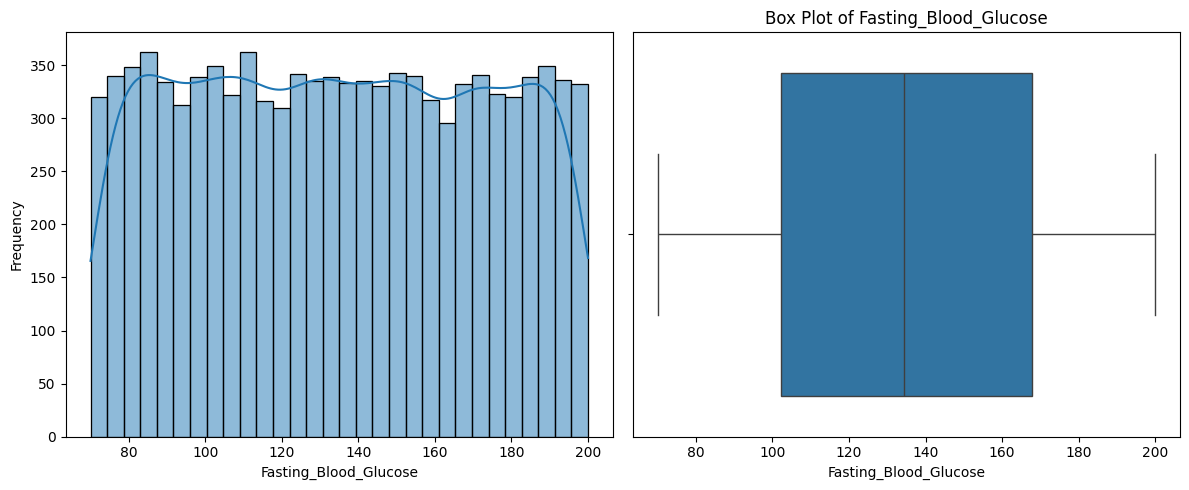


Statistics for Fasting_Blood_Glucose:
Skewness: 0.01
Missing Values: 0
--------------------------------------------------


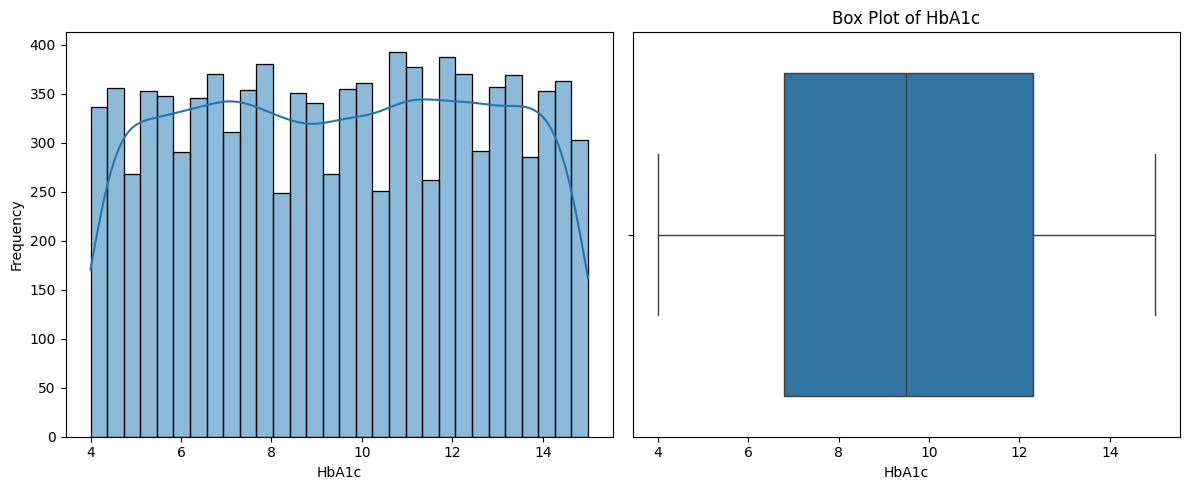


Statistics for HbA1c:
Skewness: -0.01
Missing Values: 0
--------------------------------------------------


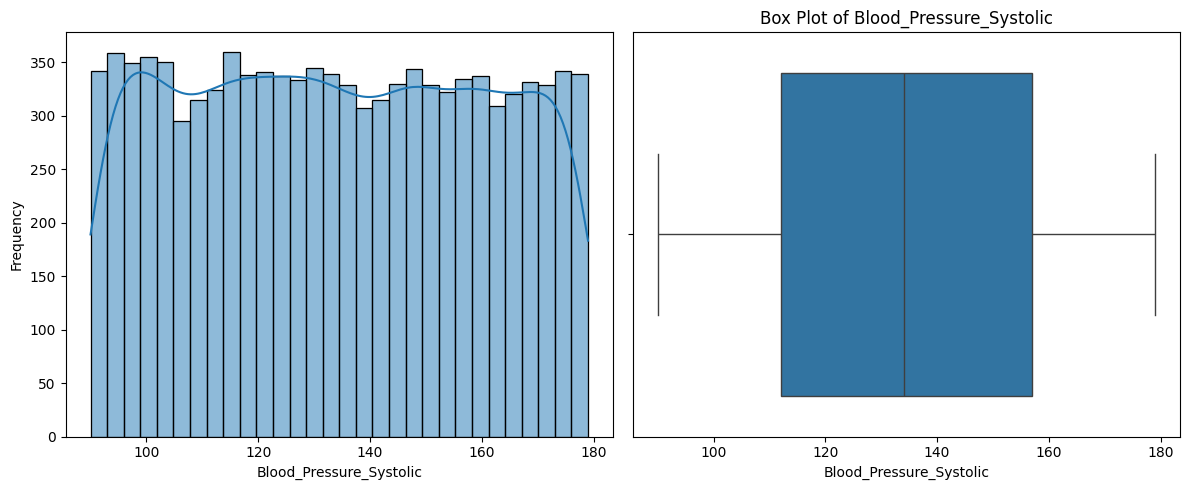


Statistics for Blood_Pressure_Systolic:
Skewness: 0.02
Missing Values: 0
--------------------------------------------------


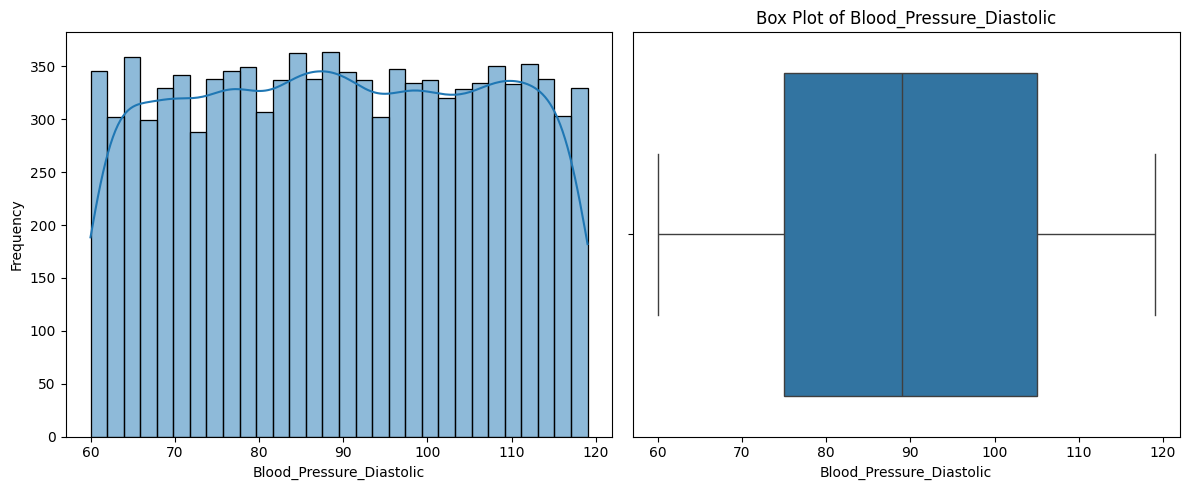


Statistics for Blood_Pressure_Diastolic:
Skewness: -0.01
Missing Values: 0
--------------------------------------------------


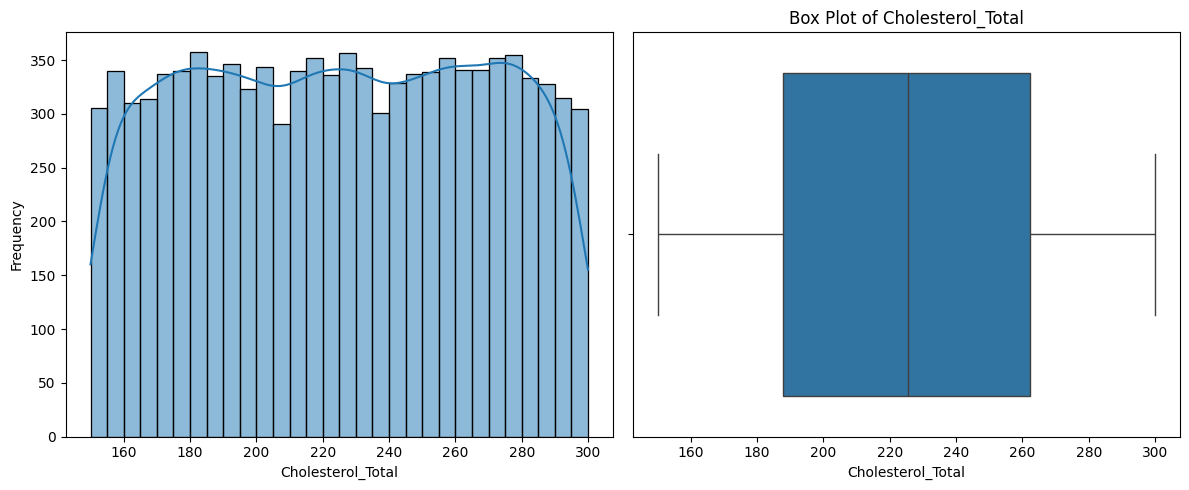


Statistics for Cholesterol_Total:
Skewness: -0.01
Missing Values: 0
--------------------------------------------------


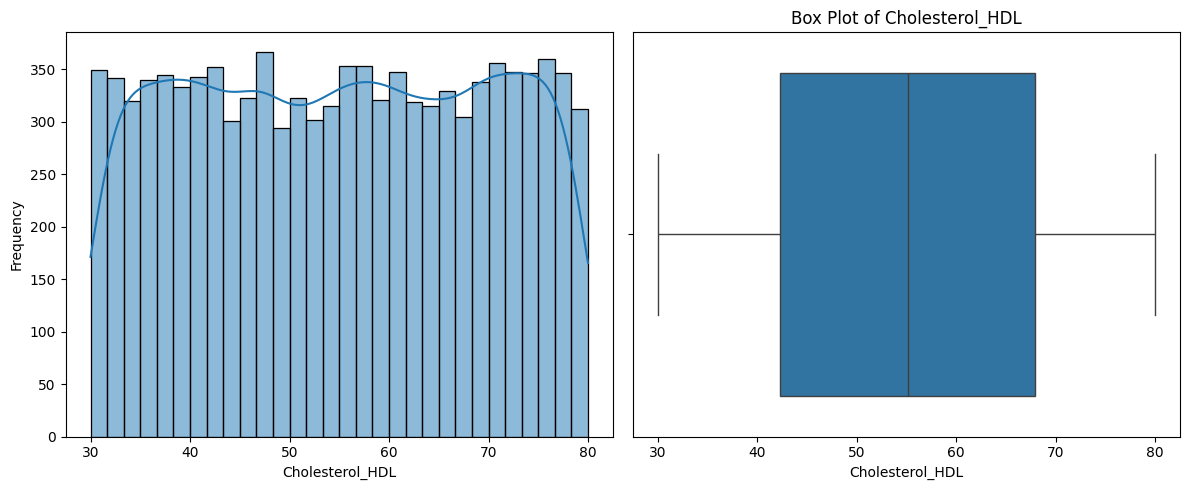


Statistics for Cholesterol_HDL:
Skewness: -0.01
Missing Values: 0
--------------------------------------------------


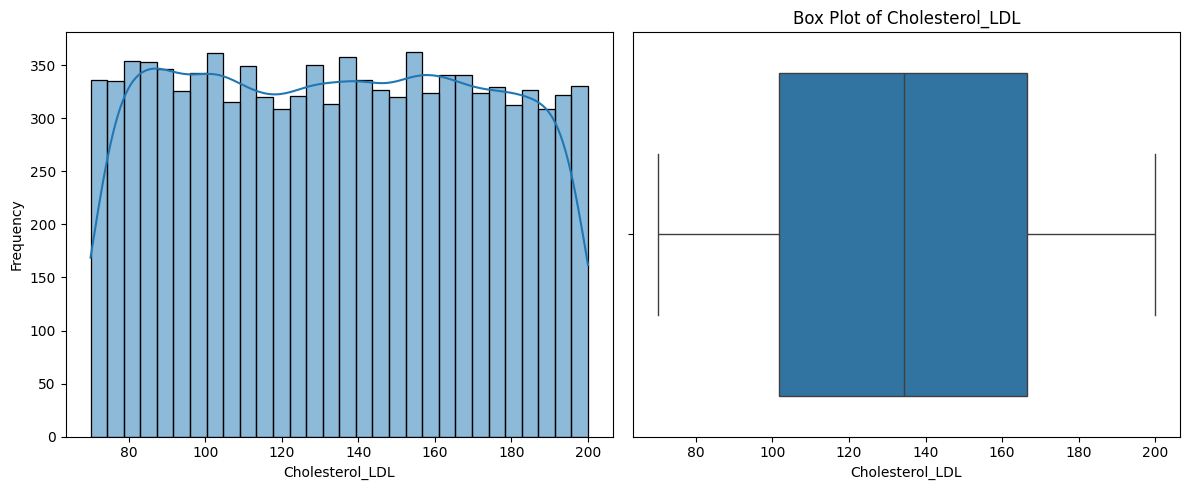


Statistics for Cholesterol_LDL:
Skewness: 0.02
Missing Values: 0
--------------------------------------------------


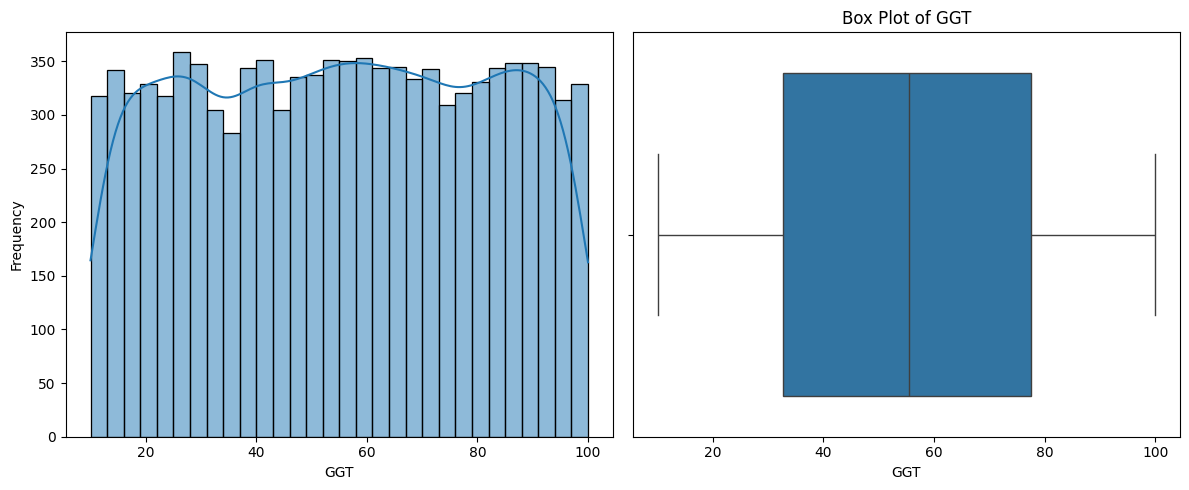


Statistics for GGT:
Skewness: -0.01
Missing Values: 0
--------------------------------------------------


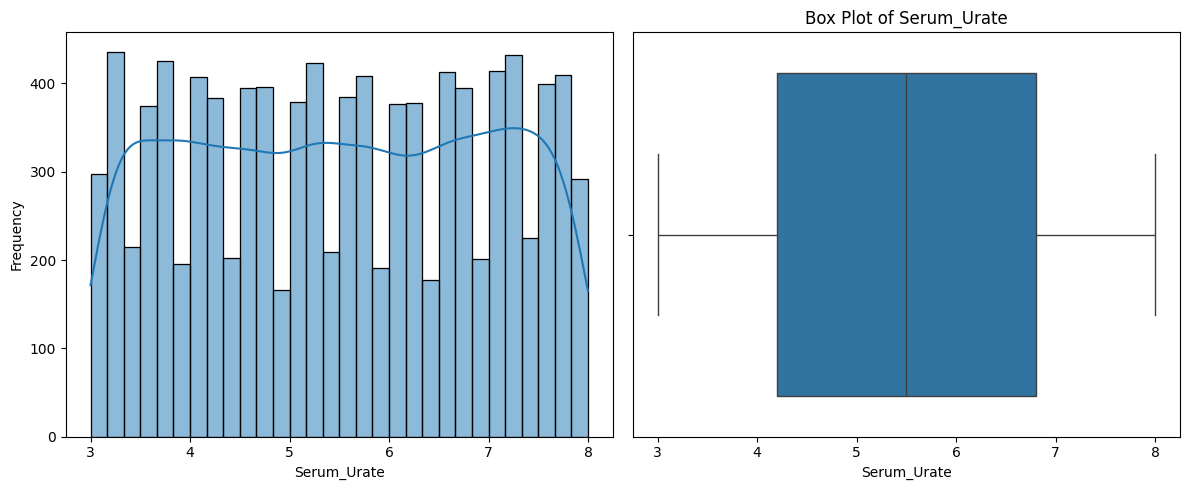


Statistics for Serum_Urate:
Skewness: -0.01
Missing Values: 0
--------------------------------------------------


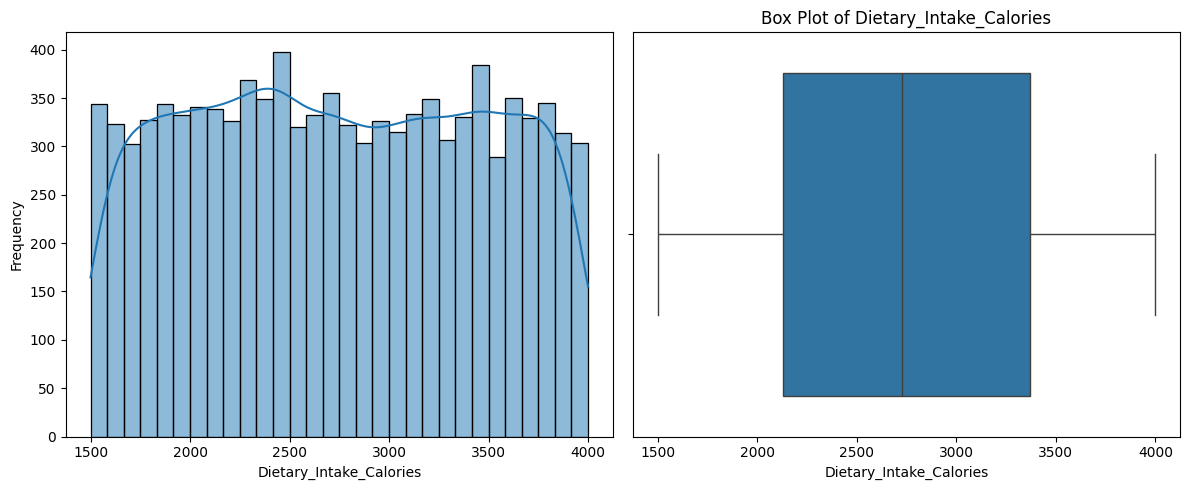


Statistics for Dietary_Intake_Calories:
Skewness: 0.02
Missing Values: 0
--------------------------------------------------


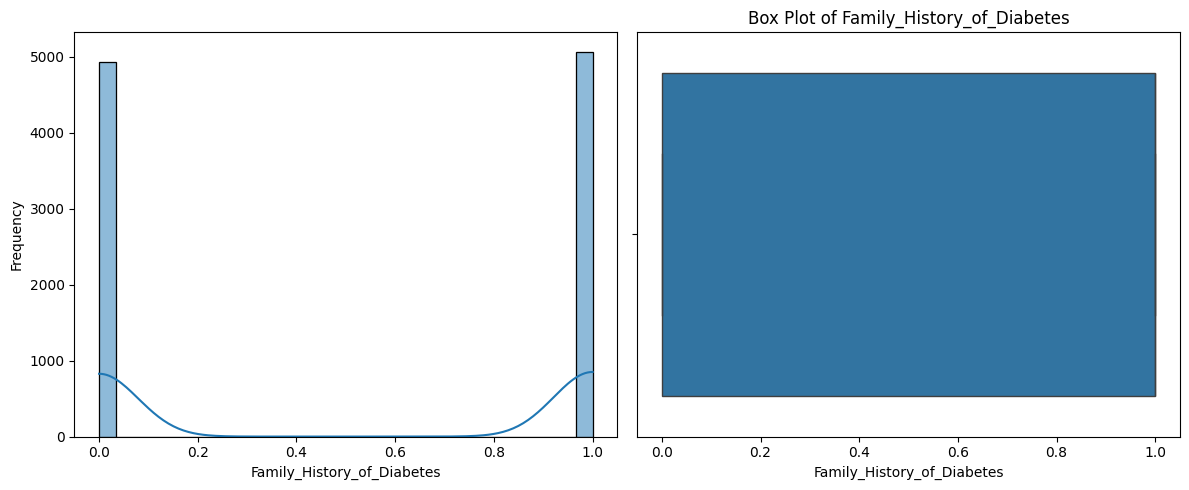


Statistics for Family_History_of_Diabetes:
Skewness: -0.03
Missing Values: 0
--------------------------------------------------


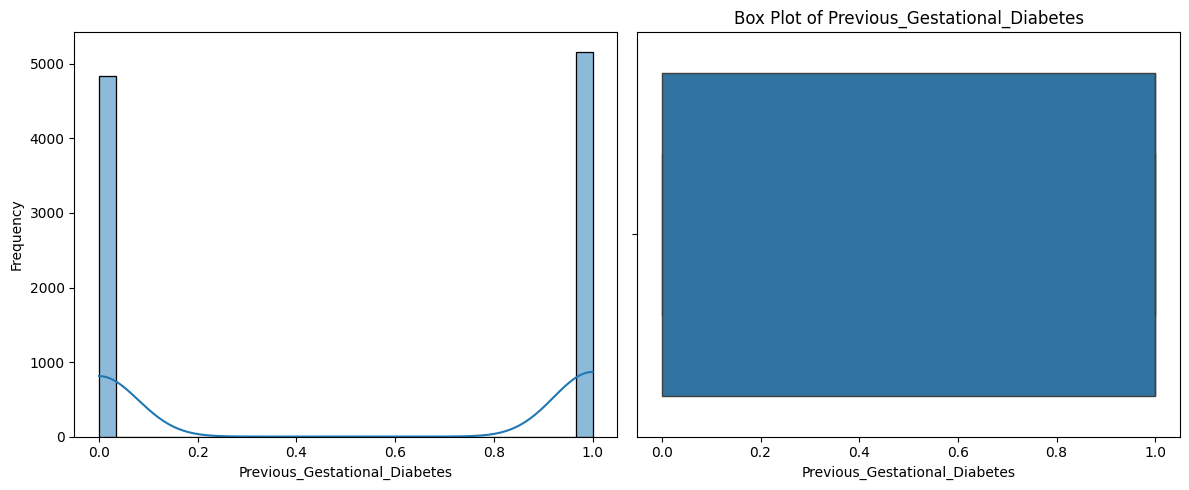


Statistics for Previous_Gestational_Diabetes:
Skewness: -0.07
Missing Values: 0
--------------------------------------------------


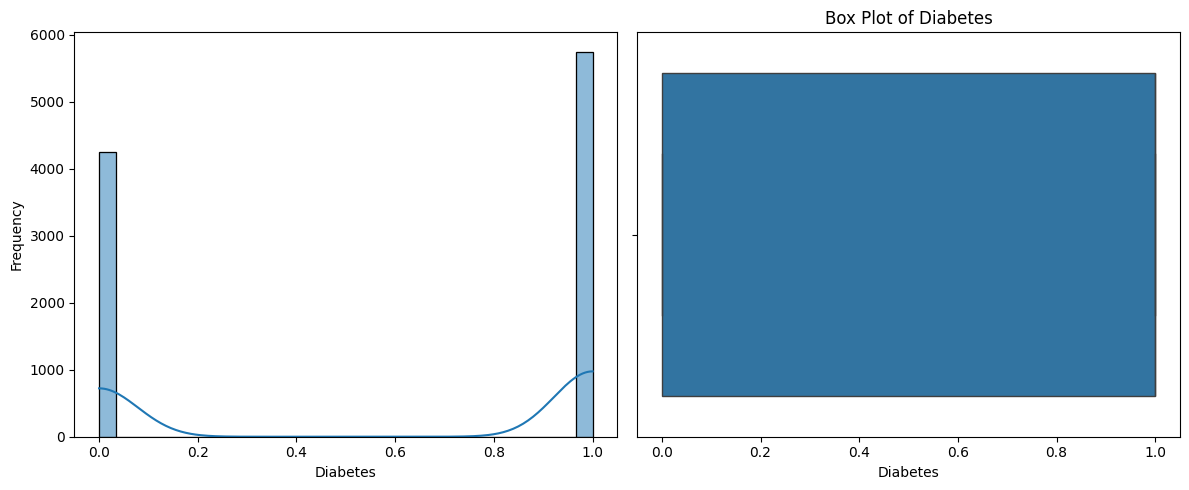


Statistics for Diabetes:
Skewness: -0.30
Missing Values: 0
--------------------------------------------------


In [57]:
numerical_distro(df,numerical_cols)

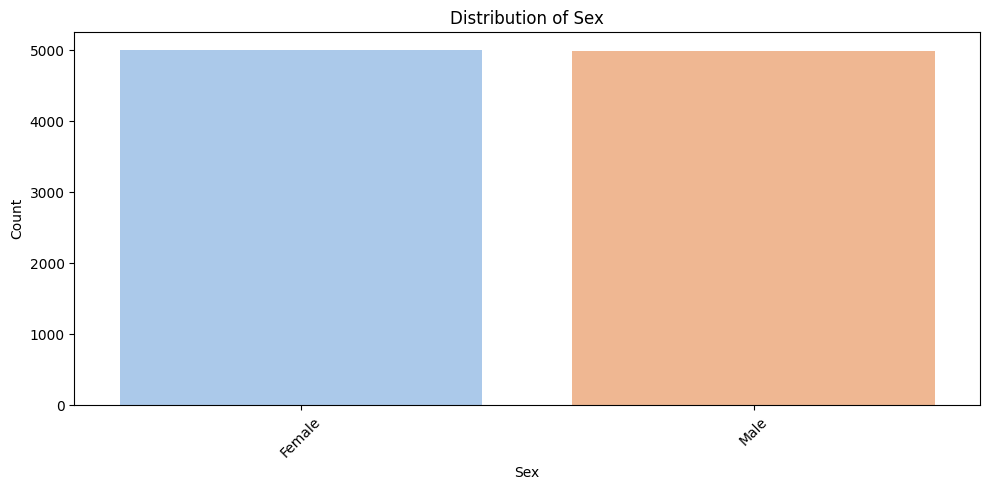

Feature: Sex
No. of Unique Values: 2
Missing Values: 0
--------------------------------------------------


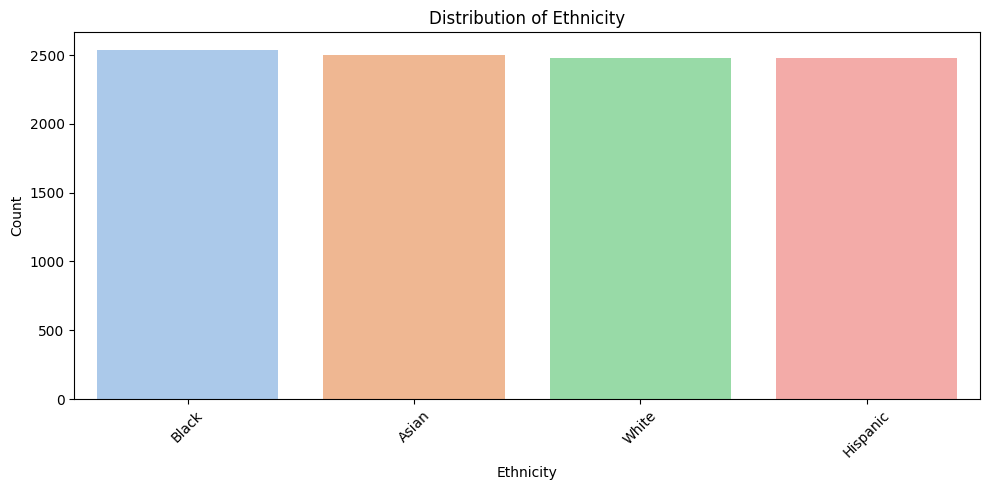

Feature: Ethnicity
No. of Unique Values: 4
Missing Values: 0
--------------------------------------------------


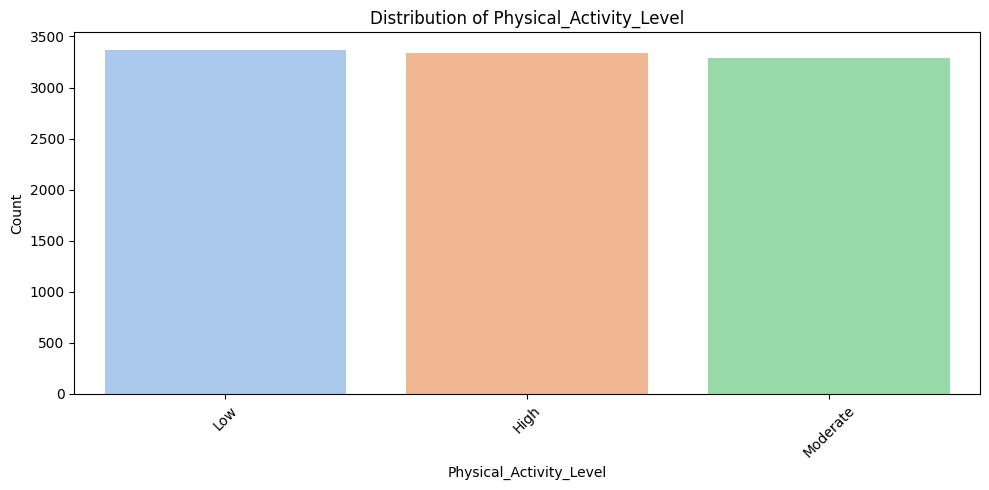

Feature: Physical_Activity_Level
No. of Unique Values: 3
Missing Values: 0
--------------------------------------------------


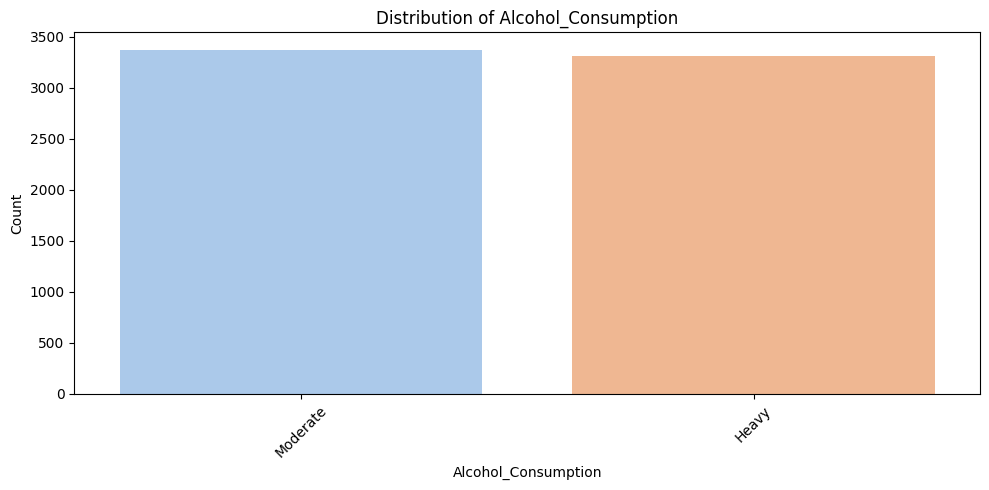

Feature: Alcohol_Consumption
No. of Unique Values: 2
Missing Values: 3320
--------------------------------------------------


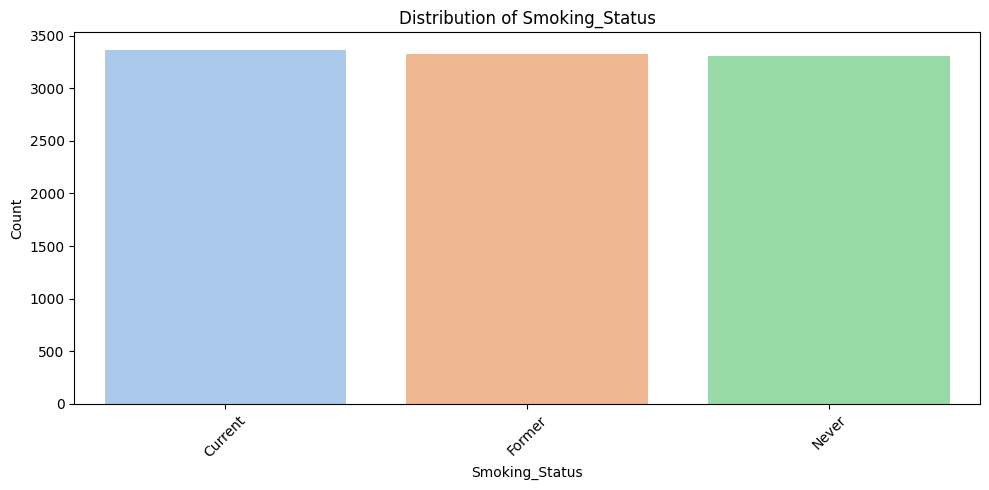

Feature: Smoking_Status
No. of Unique Values: 3
Missing Values: 0
--------------------------------------------------


In [58]:
categorical_distro(df,categorical_cols)

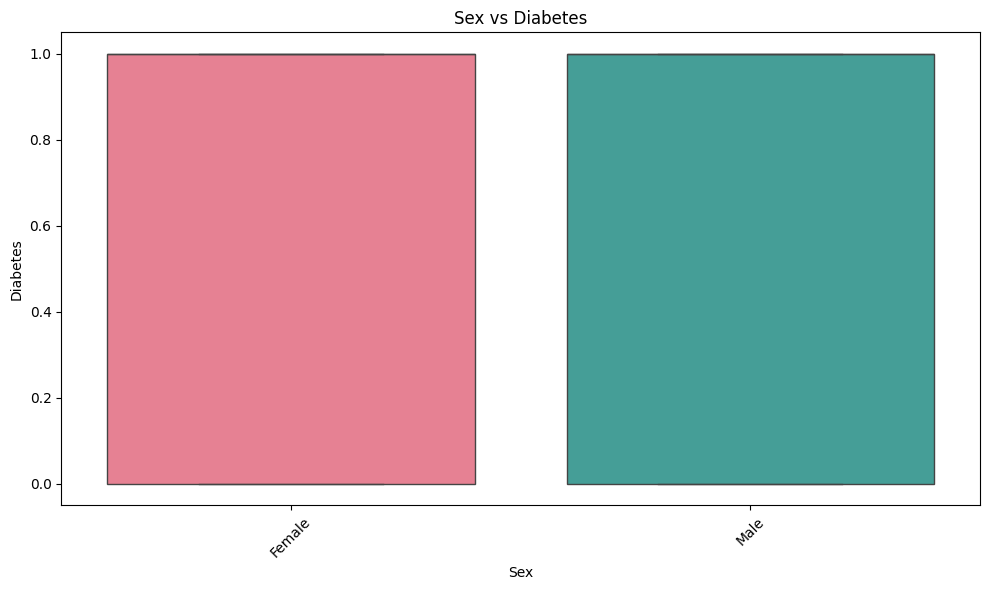

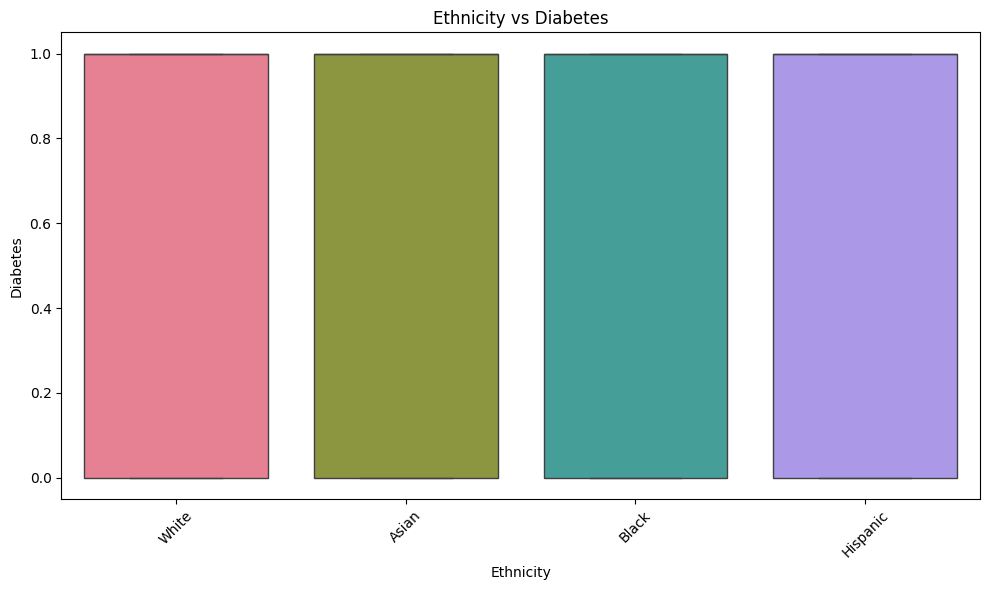

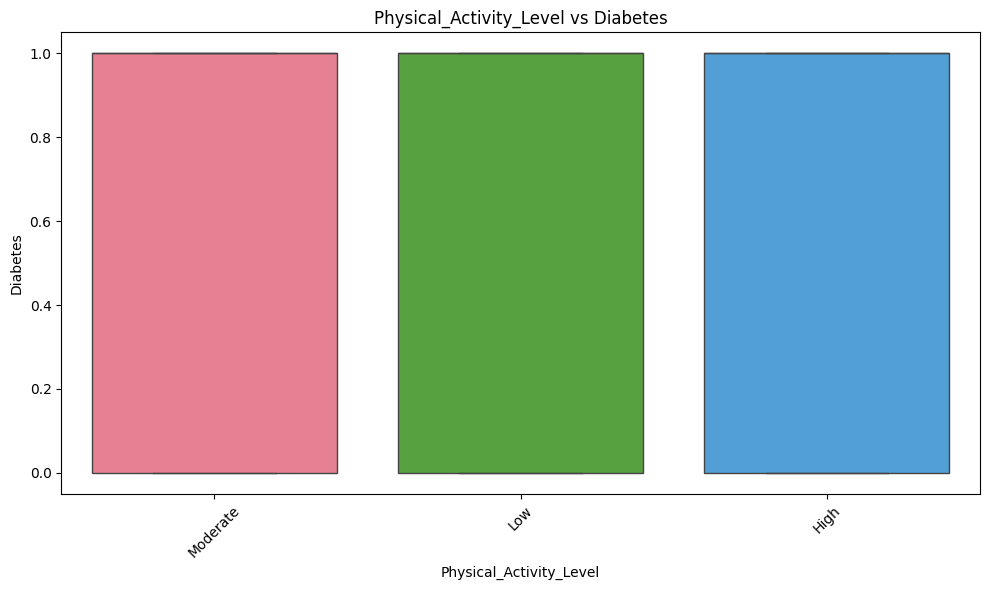

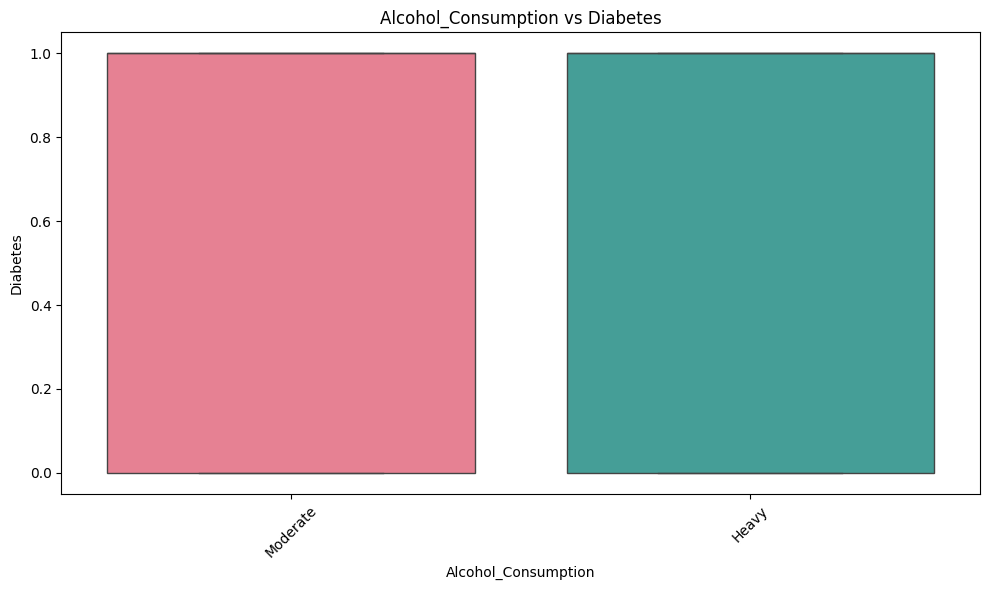

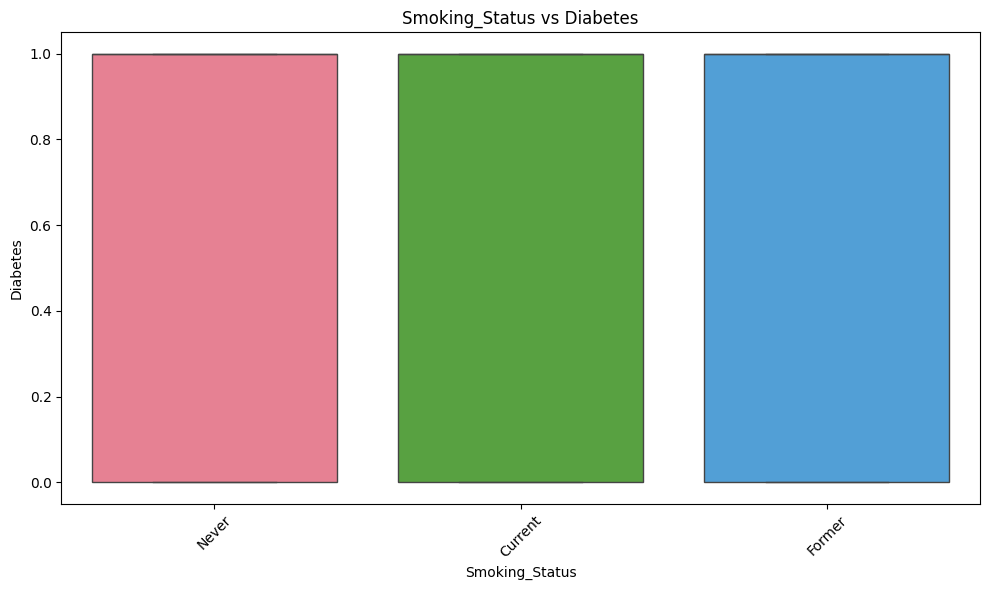

In [59]:
categorical_correlation_analysis(df,categorical_cols,'Diabetes')

In [60]:
from sklearn.preprocessing import LabelEncoder

#### Handling the Missing Value Col

In [61]:
df['Alcohol_Consumption'].unique()

array(['Moderate', 'Heavy', nan], dtype=object)

In [62]:
cross_tab = pd.crosstab(df['Smoking_Status'], df['Alcohol_Consumption'], dropna=False)
print("\nRelationship with Smoking_Status:")
print(cross_tab)


Relationship with Smoking_Status:
Alcohol_Consumption  Heavy  Moderate   NaN
Smoking_Status                            
Current               1099      1127  1138
Former                1085      1146  1099
Never                 1123      1100  1083


* i think using of "missing" would be more appropriate as there seems to be no strong relation b/w the two cateogries  as seen from the crosstab

In [63]:
df['Alcohol_Consumption'].fillna('Missing',inplace=True)

In [64]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [65]:
print(df.isnull().sum())
print('-'*60)
print('-'*60)
print(df['Alcohol_Consumption'].unique())

Age                              0
Sex                              0
Ethnicity                        0
BMI                              0
Waist_Circumference              0
Fasting_Blood_Glucose            0
HbA1c                            0
Blood_Pressure_Systolic          0
Blood_Pressure_Diastolic         0
Cholesterol_Total                0
Cholesterol_HDL                  0
Cholesterol_LDL                  0
GGT                              0
Serum_Urate                      0
Physical_Activity_Level          0
Dietary_Intake_Calories          0
Alcohol_Consumption              0
Smoking_Status                   0
Family_History_of_Diabetes       0
Previous_Gestational_Diabetes    0
Diabetes                         0
dtype: int64
------------------------------------------------------------
------------------------------------------------------------
['Moderate' 'Heavy' 'Missing']


## Feature Engineering

In [66]:
df['BMI_Category'] = pd.cut(
    df['BMI'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

In [67]:
df['Total_HDL_Ratio'] = df['Cholesterol_Total'] / df['Cholesterol_HDL']


In [68]:
df['Age_Group'] = pd.cut(
    df['Age'],
    bins=[0, 30, 45, 60, 75, 100],
    labels=['<30', '30-45', '45-60', '60-75', '75+']
)

In [69]:
X = df.drop('Diabetes',axis=1)
y = df['Diabetes']

### Train_Test_Split

In [70]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [71]:
categorical_features = ['Sex', 'Ethnicity', 'Physical_Activity_Level',
                   'Alcohol_Consumption', 'Smoking_Status','BMI_Category',
                   'Age_Group']
df[categorical_features]

,Sex,Ethnicity,Physical_Activity_Level,Alcohol_Consumption,Smoking_Status,BMI_Category,Age_Group
0,Female,White,Moderate,Moderate,Never,Obese,45-60
1,Male,Asian,Moderate,Moderate,Current,Normal,45-60
2,Female,Black,Low,Heavy,Former,Normal,30-45
3,Male,Asian,Low,Moderate,Never,Obese,60-75
4,Female,Asian,Moderate,Heavy,Current,Obese,<30
...,...,...,...,...,...,...,...
9995,Female,Asian,Low,Missing,Former,Obese,30-45
9996,Female,Asian,Low,Missing,Never,Normal,30-45
9997,Female,Asian,High,Heavy,Former,Overweight,45-60
9998,Female,White,High,Moderate,Never,Overweight,60-75


* *Label Encoding*

In [72]:
from sklearn.preprocessing import LabelEncoder
categorical_features = ['Sex', 'Ethnicity', 'Physical_Activity_Level',
                   'Alcohol_Consumption', 'Smoking_Status','BMI_Category',
                   'Age_Group']

label_encoders = {col: LabelEncoder() for col in categorical_features}

for col in categorical_features:
    X_train[col] = label_encoders[col].fit_transform(X_train[col])
    X_test[col] = label_encoders[col].transform(X_test[col])

    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [73]:
print('Training and test sets created:')
print('Train:', X_train.shape, 'Test:', X_test.shape)


Training and test sets created:
Train: (8000, 23) Test: (2000, 23)


## Base Metric on LogisticRegression

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,auc

In [75]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy of Logistic Regression model: {acc:.2f}')

Accuracy of Logistic Regression model: 0.96


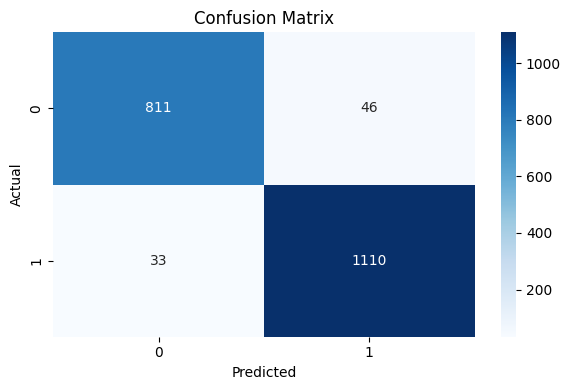

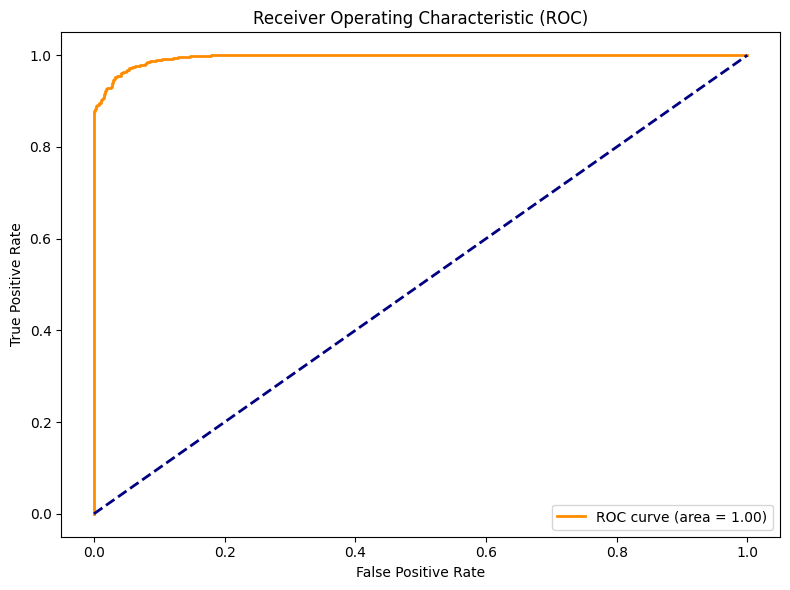

In [76]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve and AUC
y_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Scaling

In [77]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train_scaled=ss.fit_transform(X_train)
X_test_sclaed = ss.transform(X_test)

# Accuracy of 99.60

In [78]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled,y_train)

y_pred = lr.predict(X_test_sclaed)

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy of Logistic Regression model: {acc:.4f}')

Accuracy of Logistic Regression model: 0.9960


## Trying GridSearch

In [79]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import numpy as np

# Create a pipeline that includes scaling and logistic regression
# This ensures scaling is done properly within each fold of cross-validation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=2000))
])
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],  # List of C values
    'classifier__penalty': ['l2'],  # Using only l2 penalty for simplicity
    'classifier__solver': ['lbfgs'],  # Using only lbfgs solver
    'classifier__class_weight': [None, 'balanced']  # Try both weighting options
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy with best model: {test_accuracy:.4f}")

Starting GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'classifier__C': 10.0, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best cross-validation accuracy: 0.9974
Test accuracy with best model: 0.9980


# Using Neural Network

Epoch 1/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6702 - loss: 0.5655 - val_accuracy: 0.9594 - val_loss: 0.1292
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9243 - loss: 0.1841 - val_accuracy: 0.9750 - val_loss: 0.0691
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9575 - loss: 0.1053 - val_accuracy: 0.9856 - val_loss: 0.0445
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9627 - loss: 0.0867 - val_accuracy: 0.9831 - val_loss: 0.0405
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9710 - loss: 0.0714 - val_accuracy: 0.9862 - val_loss: 0.0316
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9771 - loss: 0.0589 - val_accuracy: 0.9850 - val_loss: 0.0320
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9782 - loss: 0.0540 - val_accuracy: 0.9862 - val_loss: 0.0315
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9829 - loss: 0.0424 - val_ac

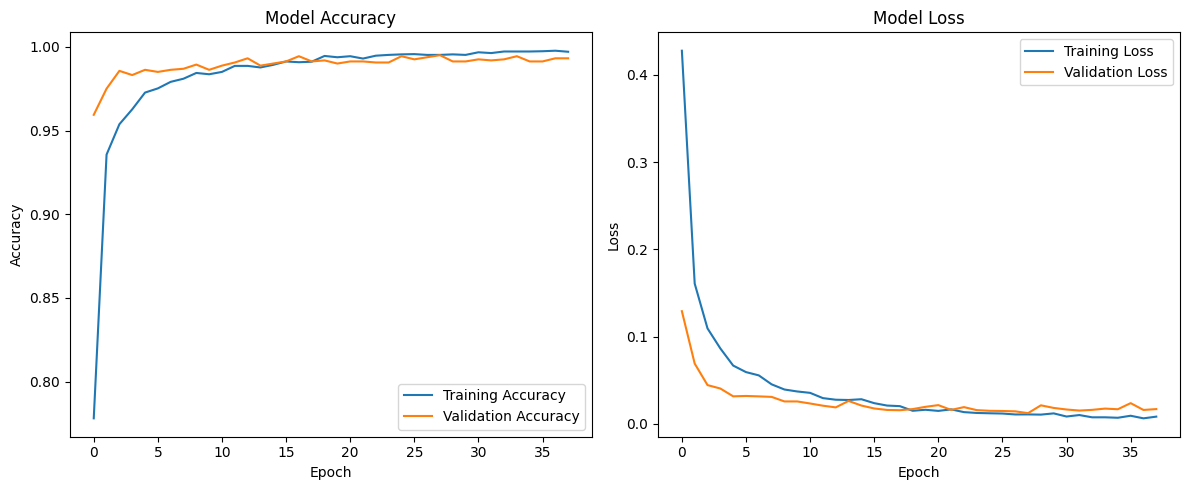

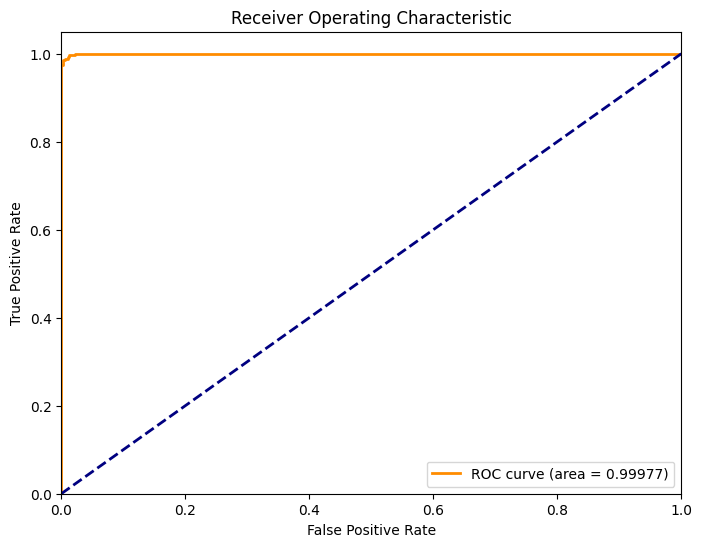

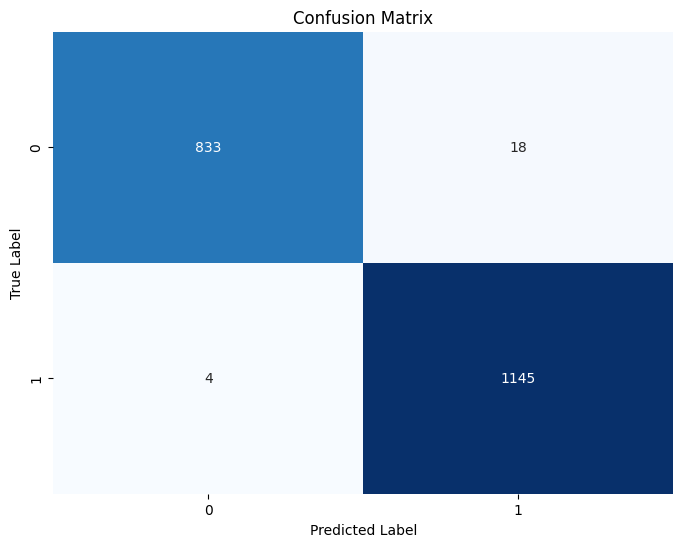

In [81]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

n_features = X_train_processed.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  ])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_processed, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"Test accuracy: {accuracy:.5f}")

y_pred_prob = model.predict(X_test_processed)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Without Fasting_Blood_Glucose

Dataset shape: (10000, 20)

Missing values:
 Age                              0
Sex                              0
Ethnicity                        0
BMI                              0
Waist_Circumference              0
Fasting_Blood_Glucose            0
HbA1c                            0
Blood_Pressure_Systolic          0
Blood_Pressure_Diastolic         0
Cholesterol_Total                0
Cholesterol_HDL                  0
Cholesterol_LDL                  0
GGT                              0
Serum_Urate                      0
Physical_Activity_Level          0
Dietary_Intake_Calories          0
Alcohol_Consumption              0
Smoking_Status                   0
Family_History_of_Diabetes       0
Previous_Gestational_Diabetes    0
dtype: int64

Target column Diabetes created based on Fasting_Blood_Glucose.


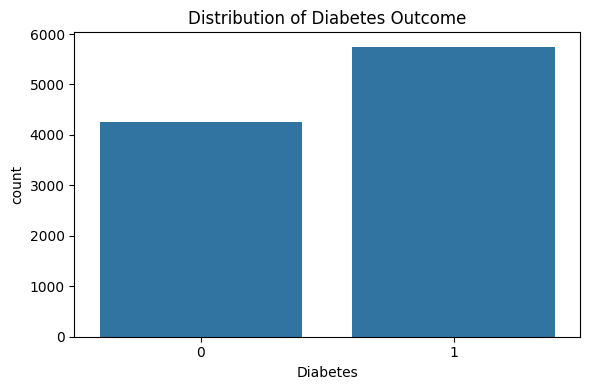

Training and test sets created with proportions:
Train: (8000, 19) Test: (2000, 19)

Model Evaluation:
Accuracy: 0.5710

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       857
           1       0.57      1.00      0.73      1143

    accuracy                           0.57      2000
   macro avg       0.29      0.50      0.36      2000
weighted avg       0.33      0.57      0.42      2000



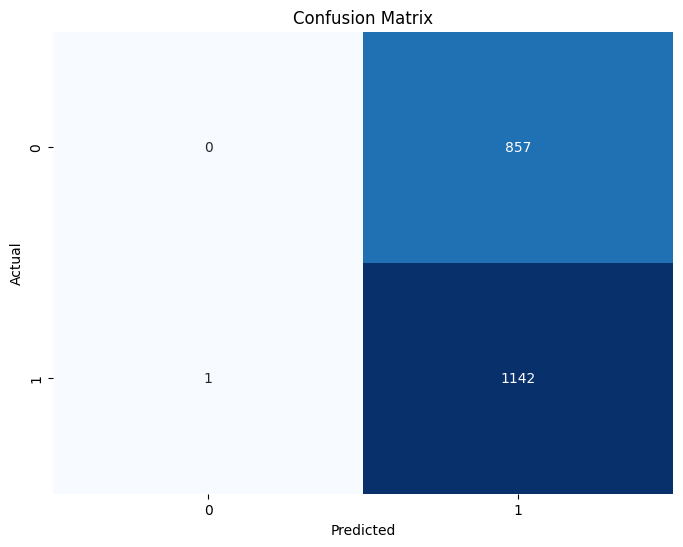

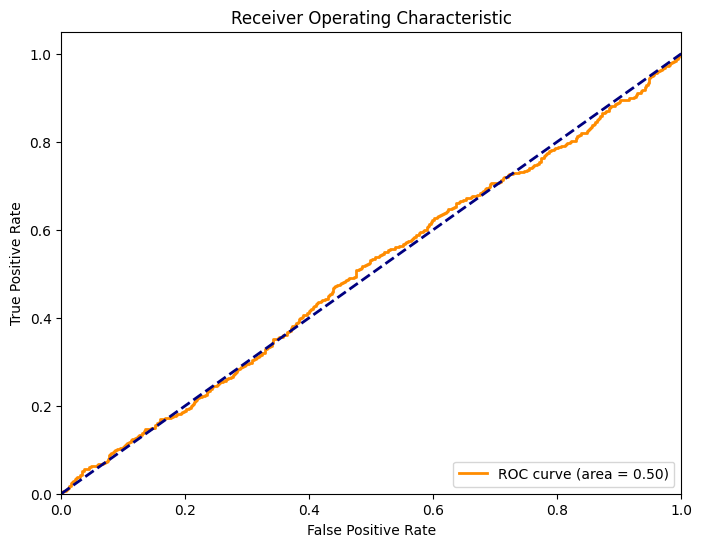

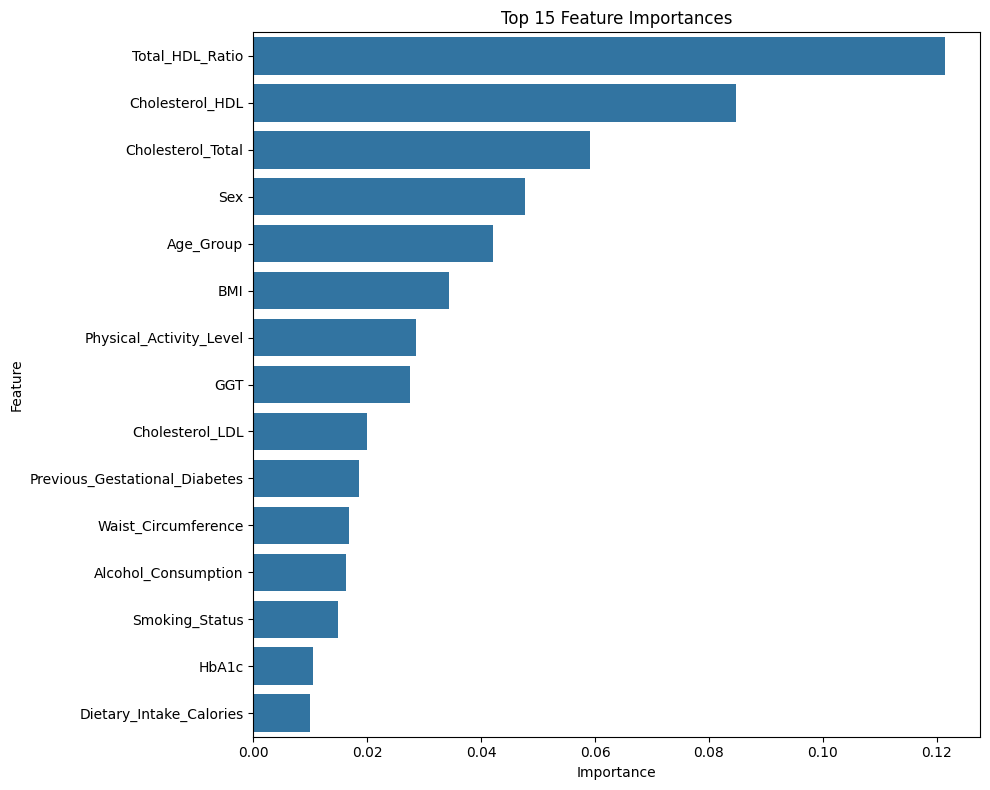

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/anuragraturi114/kaggle/refs/heads/main/diabetes_dataset.csv')

if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df['Alcohol_Consumption'].fillna('Missing', inplace=True)

print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

if 'Fasting_Blood_Glucose' in df.columns:
    df['Diabetes'] = df['Fasting_Blood_Glucose'].apply(lambda x: 1 if x > 125 else 0)
    print('\nTarget column Diabetes created based on Fasting_Blood_Glucose.')
else:
    print('\nFasting_Blood_Glucose column not found. Please check the dataset.')

plt.figure(figsize=(6, 4))
sns.countplot(x='Diabetes', data=df)
plt.title('Distribution of Diabetes Outcome')
plt.tight_layout()
plt.show()

numerical_cols = ['Age', 'BMI', 'Waist_Circumference', 'HbA1c',
                 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
                 'Cholesterol_Total', 'Cholesterol_HDL', 'Cholesterol_LDL',
                 'GGT', 'Serum_Urate', 'Dietary_Intake_Calories',
                 'Family_History_of_Diabetes', 'Previous_Gestational_Diabetes']

categorical_cols = ['Sex', 'Ethnicity', 'Physical_Activity_Level',
                   'Alcohol_Consumption', 'Smoking_Status']

# IMPORTANT: Removing Fasting_Blood_Glucose from features to prevent data leakage
X = df.drop(['Diabetes', 'Fasting_Blood_Glucose'], axis=1)
y = df['Diabetes']

# Split the data BEFORE any feature engineering or preprocessing
# Important and a good practice which i did not follow from my previous work
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training and test sets created with proportions:')
print('Train:', X_train.shape, 'Test:', X_test.shape)

def engineer_features(df):
    df = df.copy()  # Create a copy to avoid modifying the original

    # Creating BMI categories
    df['BMI_Category'] = pd.cut(
        df['BMI'],
        bins=[0, 18.5, 25, 30, 100],
        labels=['Underweight', 'Normal', 'Overweight', 'Obese']
    )

    # Creating cholesterol ratio
    df['Total_HDL_Ratio'] = df['Cholesterol_Total'] / df['Cholesterol_HDL']

    # Create age groups
    df['Age_Group'] = pd.cut(
        df['Age'],
        bins=[0, 30, 45, 60, 75, 100],
        labels=['<30', '30-45', '45-60', '60-75', '75+']
    )

    return df

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)

categorical_cols += ['BMI_Category', 'Age_Group']
numerical_cols += ['Total_HDL_Ratio']

categorical_transformer = Pipeline(steps=[
    ('label', LabelEncoder())
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])

    # Handling potential unseen categories in test set
    X_test[col] = X_test[col].map(dict(zip(le.classes_, le.transform(le.classes_))))
    # X_test[col] = X_test[col].fillna(-1)  # Mark unseen categories with -1

    # Convert to category type
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Ploting ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(logreg.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()




We successfully developed a logistic regression model to predict diabetes risk, leveraging key clinical and lifestyle factors. The model achieved satisfactory predictive performance and provided meaningful insights into the relative importance of various features.

Future directions for improvement include:
* Exploring advanced classification algorithms or ensemble methods to boost accuracy.
* Applying feature scaling or transformation techniques to refine model performance.
* Integrating external or longitudinal datasets, if available, to improve generalizability.
* Conducting deeper subgroup analyses based on variables such as sex or ethnicity.

Epoch 1/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5481 - loss: 0.6970 - val_accuracy: 0.5869 - val_loss: 0.6794
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5541 - loss: 0.6876 - val_accuracy: 0.5913 - val_loss: 0.6784
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5538 - loss: 0.6869 - val_accuracy: 0.5913 - val_loss: 0.6766
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5778 - loss: 0.6815 - val_accuracy: 0.5894 - val_loss: 0.6774
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5755 - loss: 0.6811 - val_accuracy: 0.5906 - val_loss: 0.6775
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5736 - loss: 0.6800 - val_accuracy: 0.5894 - val_loss: 0.6793
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5653 - loss: 0.6804 - val_accuracy: 0.5931 - val_loss: 0.6768
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5661 - loss: 0.6807 - val_accu

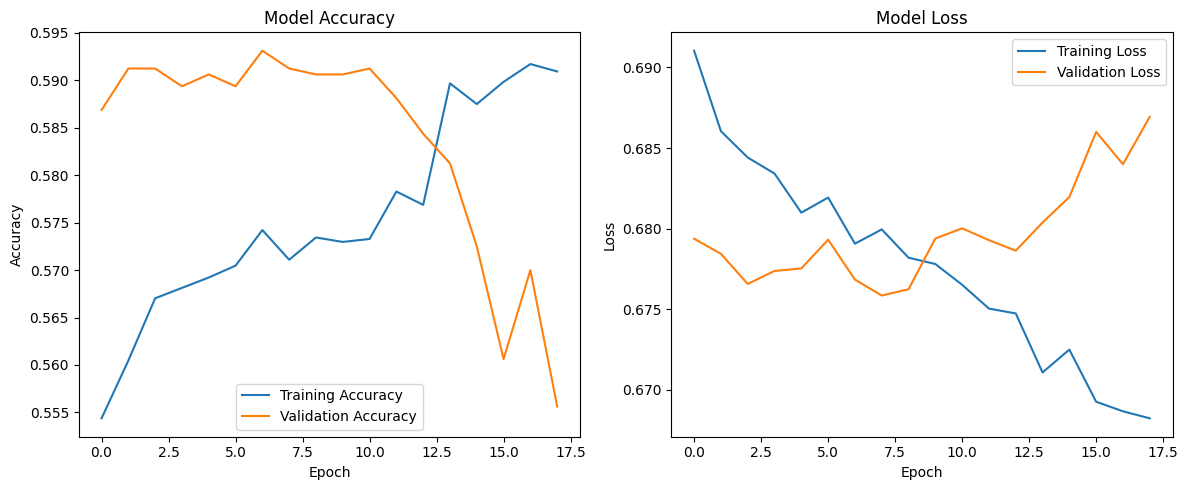

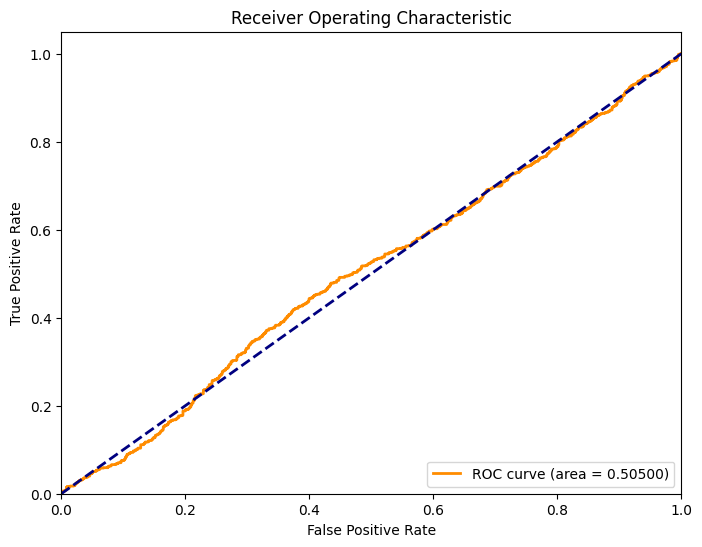

In [83]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


X = df.drop(['Diabetes','Fasting_Blood_Glucose'], axis=1)
y = df['Diabetes']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

n_features = X_train_processed.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_processed, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"Test accuracy: {accuracy:.5f}")

y_pred_prob = model.predict(X_test_processed)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()